In [1]:
import jax
import jax.numpy as jnp

from jax.random import PRNGKey, split
from jax.flatten_util import ravel_pytree

import optax
import aevb
from aevb import AEVB

import matplotlib.pyplot as plt

### Normal Like Tree

(array([ 4.,  9., 44., 61., 67., 57., 45.,  9.,  3.,  1.]),
 array([-2.98597527, -2.32459497, -1.66321468, -1.00183439, -0.3404541 ,
         0.32092619,  0.98230648,  1.64368677,  2.30506706,  2.96644735,
         3.62782764]),
 <BarContainer object of 10 artists>)

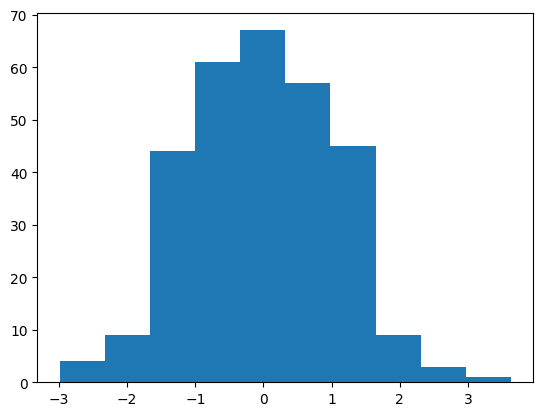

In [2]:
rng_key = PRNGKey(123)

tree = {"w": jnp.array([1., 2.]), "b": jnp.array([2.])}
noise_tree = aevb.normal_like_tree(rng_key, tree, n_samples=100)
tree_1d, _ = ravel_pytree(noise_tree)

plt.hist(tree_1d)

### Normal Log Likelihood fn

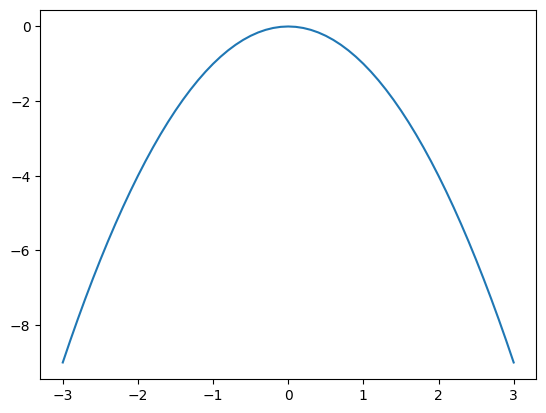

In [3]:
apply_fn = lambda params, z: jnp.arange(-3., 3.1, .1)
x = jnp.array([0.])
out = aevb.normal_loglikelihood_fn(apply_fn, None, None, x)
plt.plot(apply_fn(None, None), out)

### Reparameterized Sample Loc Scale

(array([ 6.,  2.,  6., 16., 22., 18., 18.,  7.,  3.,  2.]),
 array([29.47710419, 30.49644089, 31.51577568, 32.53511047, 33.55444717,
        34.57378387, 35.59312057, 36.61245728, 37.63179016, 38.65112686,
        39.67046356]),
 <BarContainer object of 10 artists>)

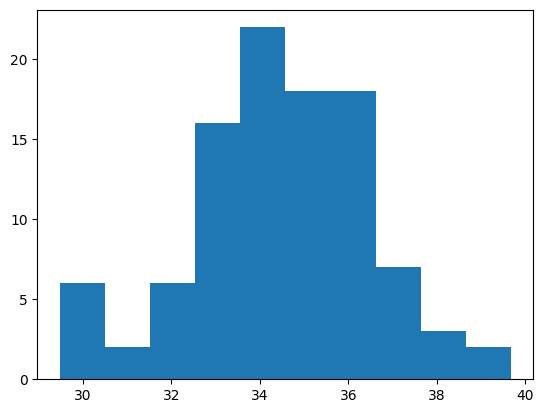

In [4]:
rng_key = PRNGKey(104)
loc = jnp.array([34.,])
scale = jnp.array([2.,])

out = aevb.reparameterized_sample_loc_scale(rng_key, loc, scale, 100)
out_1d, _ =  ravel_pytree(out)

plt.hist(out_1d)

### Unit Normal KL

In [5]:
mu = jnp.zeros((2,1))
sigma = jnp.ones((2,1))

out = aevb.unit_normal_kl(mu, sigma)
print(f"Result from ((0, 0), (1, 1)): {out}")

mu = jnp.ones((2, 1)) * 0.5
sigma = jnp.ones((2, 1)) * 1.5

out = aevb.unit_normal_kl(mu, sigma)
print(f"Result from ((0.5, 1.5, 0.5, 1.5)): {out}")

mu = jnp.ones((2, 1)) * 4
sigma = jnp.ones((2, 1)) * 5

out = aevb.unit_normal_kl(mu, sigma)
print(f"Result from ((4, 5, 4, 5)): {out}")


Result from ((0, 0), (1, 1)): 0.0
Result from ((0.5, 1.5, 0.5, 1.5)): 0.6890697479248047
Result from ((4, 5, 4, 5)): 36.781124114990234


### Tractable KL Step

In [8]:
# Super simple toy problem

rng_key = PRNGKey(47)
rec_params = {"w": jnp.array([[4., 1.], [2., 2.]]), "b": jnp.array([[1.]])}
gen_params = {"w": jnp.array([[2.], [1.]]), "b": jnp.array([[1.]])}

optimizer = optax.sgd(1e-3)
opt_state = optimizer.init((rec_params, gen_params))

n_samples = 1
aevb_state = aevb.AEVBState(rec_params, gen_params, opt_state)

rec_apply_fn = lambda params, x: params['w'].T @ x + params['b']
gen_apply_fn = lambda params, x: params['w'] @ x.T + params['b']

x = jnp.array([[3.], [7.]])
rng_key = PRNGKey(33)

for _ in range(100):
    aevb_state, aevb_info = aevb.tractable_kl_step(
            rng_key,
            aevb_state,
            x,
            rec_apply_fn,
            gen_apply_fn,
            optimizer,
            n_samples,
        )
    print(f"Loss: {aevb_info.loss}")


Loss: 6845.8671875
Loss: 279.6884460449219
Loss: 469.284912109375
Loss: 671.535888671875
Loss: 545.6845703125
Loss: 214.20310974121094
Loss: 53.650238037109375
Loss: 38.49954605102539
Loss: 34.86107635498047
Loss: 32.03285217285156
Loss: 29.533939361572266
Loss: 27.313804626464844
Loss: 25.340469360351562
Loss: 23.585983276367188
Loss: 22.025575637817383
Loss: 20.637264251708984
Loss: 19.401535034179688
Loss: 18.30107879638672
Loss: 17.320528030395508
Loss: 16.44625473022461
Loss: 15.666154861450195
Loss: 14.969500541687012
Loss: 14.346758842468262
Loss: 13.789487838745117
Loss: 13.290184020996094
Loss: 12.842195510864258
Loss: 12.439623832702637
Loss: 12.077232360839844
Loss: 11.750383377075195
Loss: 11.454962730407715
Loss: 11.187320709228516
Loss: 10.944229125976562
Loss: 10.722820281982422
Loss: 10.520562171936035
Loss: 10.335205078125
Loss: 10.16476821899414
Loss: 10.007492065429688
Loss: 9.86181926727295
Loss: 9.7263822555542
Loss: 9.599966049194336
Loss: 9.481502532958984
Loss: 

### Interface

In [9]:
rng_key = PRNGKey(47)
rec_params = {"w": jnp.array([[4., 1.], [2., 2.]]), "b": jnp.array([[1.]])}
gen_params = {"w": jnp.array([[2.], [1.]]), "b": jnp.array([[1.]])}

optimizer = optax.sgd(1e-3)
opt_state = optimizer.init((rec_params, gen_params))

n_samples = 1


rec_apply_fn = lambda params, x: params['w'].T @ x + params['b']
gen_apply_fn = lambda params, x: params['w'] @ x.T + params['b']

x = jnp.array([[3.], [7.]])

aevb_algorithm = AEVB.init(rec_apply_fn, gen_apply_fn, optimizer, 1)
state = aevb_algorithm.init(rec_params, gen_params)

for _ in range(100):
    key, rng_key = split(rng_key)
    state, info = jax.jit(aevb_algorithm.step)(rng_key, state, x)
    print(f"Loss: {info.loss}")


Loss: 6528.4189453125
Loss: 713.9888916015625
Loss: 326.65374755859375
Loss: 16.734729766845703
Loss: 39.879425048828125
Loss: 18.333824157714844
Loss: 13.029752731323242
Loss: 24.200103759765625
Loss: 55.51762771606445
Loss: 18.921329498291016
Loss: 13.056443214416504
Loss: 13.71206283569336
Loss: 13.076598167419434
Loss: 12.833662033081055
Loss: 12.930419921875
Loss: 13.128152847290039
Loss: 13.576057434082031
Loss: 12.200398445129395
Loss: 15.885600090026855
Loss: 13.179248809814453
Loss: 15.479445457458496
Loss: 15.179513931274414
Loss: 15.063207626342773
Loss: 13.071944236755371
Loss: 20.041887283325195
Loss: 13.361501693725586
Loss: 14.976572036743164
Loss: 13.476056098937988
Loss: 13.250377655029297
Loss: 12.120325088500977
Loss: 11.911412239074707
Loss: 20.42237663269043
Loss: 31.348533630371094
Loss: 13.465300559997559
Loss: 11.81688117980957
Loss: 11.90279769897461
Loss: 13.94871997833252
Loss: 12.647665023803711
Loss: 13.016170501708984
Loss: 12.418743133544922
Loss: 11.6550